**به دلیل جحم بالای فایل مدل،مدل در درایو اپلود شده و لینک درایو در ادامه و در فایل متنی داخل ریپازیتوری قرار داده شده است.**

link: https://drive.google.com/file/d/1v6A0tA_RiYU-5H8lNLKmH39Vg4NBXFjB/view?usp=sharing

توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [ ]:
## download data

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




در این قسمت شش تابع گفته شده پیاده سازی شده است.

تابع جابجایی:از تصویر اصلی  ۲ تصویر ایجاد میکنیم. با سایز ۲۲۴ در ۲۲۴ از مرکز تصویر اصلی میبریم بعد به صورت رندوم یک مقدار جابه جا شده ی ان را  از تصویر اصلی پیدا میکنیم  و با همین سایز برش میزنیم  که ۲ تصویر در نهایت ایجاد شود.

تابع چرخش:در این تابع تصویر را به اندازه دلخواه میچرخانیم.
برای اینکه ناحیه مشکی رنک ایجاد نشود ابتدا از مرکزتصویر اصلی یک تصویر  ه۲۲۴ در ۲۲۴ برش میزنیم به عنوان تصویر اول و بعد چرخش را روی تصویر اصلی اعمال میکنیم  سپس برش میزنیم به عنوان تصویر دوم و به این صورت ناحیه مشکی رنگ ایجاد نمیشود.

تابع اسکیل: ابتدا از وسط تصویر اصلی یک تصویر با سایز ۲۲۴ در ۲۲۴ برش میزنیم و عکس اول را میسازیم. سپس تغییر یافته اش را با همین سایز برش میزنیم.در واقع  تصویر اصلی رو بزرگتر یا کوچکتر میکنیم و سپس از تصویر یک تصویر با سایز ۲۲۴ در ۲۲۴ برش میزنیم.

برای سه تابع اخر به ترتیب برای تغییر روشنایی ابتدا مقادیر پیسکل های تصویر را در یک عدد رندوم ضرب میکنیم . سپس به بازه ای 0 تا 255 برمیگردانیم. بدین صورت میزان روشنایی تصویر تغییر میکن. برای تابع بعدی از فیلتر گوسی استفاده شده است که در واقع با میانگین گیری با وزن گوسی تصویر را مات یا همان بلر میکند. و در اخر برای اضافه کردن نویز به تصویر به تمامی پیسکل های سه کانال رنگی مقدار نویز گوسی با تابع رندوم نرمال اضافه میکنیم که میانگین این توزیع برابر با صفر و واریانس ان یک عدد دلخواه در بازه ای 15 تا 25 میباشد.

In [ ]:
# function 1
def displacement(img):
    rows, cols, _ = img.shape
    # Define amount of displacement
    dx = 10
    dy = 10
    # Define the transformation matrix for displacement
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    # Use warpAffine to apply the displacement
    img = cv2.warpAffine(img, M, (cols, rows))[dx:,dy:,:]
    return img

# function 2
def rotate(img):
    original_image = img
    # Get the image dimensions
    height, width = original_image.shape[:2]
    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), 10, 1)
    # Apply the rotation
    rotated_image = cv2.warpAffine(
        original_image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)
    # Find the bounding box of the rotated image
    cos_theta = np.abs(rotation_matrix[0, 0])
    sin_theta = np.abs(rotation_matrix[0, 1])
    new_width = int((height * sin_theta) + (width * cos_theta))
    new_height = int((height * cos_theta) + (width * sin_theta))
    bounding_box_width = new_width - width
    bounding_box_height = new_height - height
    # Calculate the cropping coordinates
    crop_x = int(bounding_box_width / 2)
    crop_y = int(bounding_box_height / 2)
    # Crop the image to remove the black areas
    img = rotated_image[crop_y:(height- crop_y), crop_x:( width - crop_x )]
    return img

# function 3
def scaling(img):
    margin = 10
    # crop the image to create a Zoomed in version
    img = img[margin:img.shape[0]-margin, margin:img.shape[1]-margin,:]
    return img

# function 4
def Brightness(img):  ## for augmentation
    img = np.clip(img * 1.6, 0, 255)
    img = img.astype(np.uint8)
    return img

# function 5
def bluring(img):# for augmentation
    img = cv2.GaussianBlur(img, (5, 5), 0, 0)
    return img

# function 6
def gaussian_noise(img):#for augmentation
    row, col, ch = img.shape
    gauss = np.random.normal(0, 20, (row, col, ch))
    img = img + gauss
    # Clip values to the valid range [0, 255]
    img = np.clip(img, 0, 255)
    img = img.astype(np.uint8)
    return img

### Apply the 3 funcs and generate pair images

در این تابع ابتدا به صورت رندوم انتخاب میکنیم که یک یا دو تغییر داشته باشیم. پس از انتخاب تعداد تغییرات ،دو یا یک تابع از توابع نوشته شده در قسمت قبل را به صورت رندوم انتخاب میکنیم و روی تصویر اعمال میکنیم. خروجی تابع لیستی از دوتایی های مرتب است که در هر دوتایی اولی عکس تغییر نیافته و دومی عکس تغییر یافته است. و همین طور لیستی از لیبل ها. که لیبل ها به صورت سه تایی های مولتی هات هستند که یک یا دو درایه با مقدار یک دارند. که درایه اول نشان دهنده تغییر جابجایی،درایه دوم نشان دهنده تغییر چرخش و درایه سوم نشان دهنده تغییر اسکیلینگ میباشد. در نهایت حدود بیست هزار جفت تصویر داریم که مدل را روی ان اموزش میدهیم. و همیچنین دو هزار تصویر برای اعتبارسنجی یا همان ولیدشن.

In [ ]:
def create_pairs(dir_path,out_path):
    # Create a list of pair images, each element is (org_image, changed_image)
    list_of_pair_images = []

    # Create a list of labels (multi-hot 3D)
    list_of_labels = []

    for filename in os.listdir(dir_path):

        # create image path
        file_path = os.path.join(dir_path, filename)

        # Read images one by one
        image = cv2.imread(file_path)

        # Convert to RGB
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Choose a random number of functions (1 or 2)
        num_functions_to_choose = random.randint(1, 2)

        # List of the 3 functions, 1: displacement, 2: rotate, 3:scaling
        function_number = [1, 2, 3]

        # Choose a function randomly
        random_function_selected = random.sample(function_number,num_functions_to_choose)

        if len(random_function_selected) == 1:
            # apply 1: displacement randomly
            if random_function_selected[0] == 1:
                changed_img = displacement(image)
                changed_path = os.path.join(out_path, filename)
                if changed_img.any():
                    cv2.imwrite(changed_path, changed_img)
                    list_of_pair_images.append((file_path, changed_path))
                    temp_label = [1,0,0]
                    list_of_labels.append(temp_label)

            # apply 2: rorate randomly
            if random_function_selected[0] == 2:
                changed_img = rotate(image)
                changed_path = os.path.join(out_path, filename)
                if changed_img.any():
                    cv2.imwrite(changed_path, changed_img)
                    list_of_pair_images.append((file_path, changed_path))
                    temp_label = [0,1,0]
                    list_of_labels.append(temp_label)

            # apply 3: scaling randomly
            if random_function_selected[0] == 3:
                changed_img = scaling(image)
                changed_path = os.path.join(out_path, filename)
                if changed_img.any():
                    cv2.imwrite(changed_path, changed_img)
                    list_of_pair_images.append((file_path, changed_path))
                    temp_label = [0,0,1]
                    list_of_labels.append(temp_label)

        if len(random_function_selected) == 2:
            # print('multi hot')
            # apply displacement and rotate
            if (random_function_selected[0] == 1 and random_function_selected[1] == 2) or (random_function_selected[0] == 2 and random_function_selected[1] == 1):
                changed_img = displacement(image)
                final_img = rotate(changed_img)
                changed_path = os.path.join(out_path, filename)
                if changed_img.any():
                    cv2.imwrite(changed_path, final_img)
                    list_of_pair_images.append((file_path, changed_path))
                    temp_label = [1,1,0]
                    list_of_labels.append(temp_label)

            # apply displacement and scaling randomly
            if (random_function_selected[0] == 1 and random_function_selected[1] == 3) or (random_function_selected[0] == 3 and random_function_selected[1] == 1):
                changed_img = displacement(image)
                final_img = scaling(changed_img)
                changed_path = os.path.join(out_path, filename)
                if changed_img.any():
                    cv2.imwrite(changed_path, final_img)
                    list_of_pair_images.append((file_path, changed_path))
                    temp_label = [1,0,1]
                    list_of_labels.append(temp_label)

            # apply rotate and scaling randomly
            if (random_function_selected[0] == 2 and random_function_selected[1] == 3) or (random_function_selected[0] == 3 and random_function_selected[1] == 2):
                changed_img = rotate(image)
                final_img = scaling(changed_img)
                changed_path = os.path.join(out_path, filename)
                if changed_img.any():
                    cv2.imwrite(changed_path, final_img)
                    list_of_pair_images.append((file_path, changed_path))
                    temp_label = [0,1,1]
                    list_of_labels.append(temp_label)

    return list_of_pair_images, list_of_labels

In [ ]:
!mkdir trainChanged
!mkdir testValChanged

In [ ]:
# Apply the create pairs function

dir_path = '/content/ADEChallengeData2016/images/training'
out_path = '/content/trainChanged'
# dir_path = '/kaggle/working/ADEChallengeData2016/images/training'
# out_path = '/kaggle/working/trainChanged'
train_pairs, train_labels = create_pairs(dir_path,out_path)

dir_path = '/content/ADEChallengeData2016/images/validation'
out_path = '/content/testValChanged'

# dir_path = '/kaggle/working/ADEChallengeData2016/images/validation'
# out_path = '/kaggle/working/testValChanged'
test_val_pairs, test_val_labels = create_pairs(dir_path, out_path)

# Print size of data sets
print('Trainset Size:', len(train_pairs))
print('Trainset Label Size:', len(train_labels))

print('Test Val set Size:', len(test_val_pairs))
print('Test Val set Label Size:', len(test_val_labels))

Trainset Size: 20210
Trainset Label Size: 20210
Test Val set Size: 2000
Test Val set Label Size: 2000


در این قسمت کلاس دیتاست پیاده سازی شده است. در ادامه دیتاست های ساخته شده را به دیتالودر میدهیم و دیتاست را به بسته های هشت تایی تقسیم میکنیم.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


class CustomDataset(Dataset):
    def __init__(self, image_paths_list, labels, transform=None):
        self.image_paths_list = image_paths_list
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths_list)

    def __getitem__(self, index):
        img_path1, img_path2 = self.image_paths_list[index]
        image1 = Image.open(img_path1).convert('RGB')
        image2 = Image.open(img_path2).convert('RGB')

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        label = self.labels[index]

        return image1, image2, label


In [ ]:
# List of labels for training set
train_labels = train_labels
# List of labels for validation set
val_labels = test_val_labels
# List of labels for test set
test_labels = test_val_labels

# Create instances of the CustomDataset with labels
train_dataset = CustomDataset(train_pairs, train_labels, transform=custom_transform)
val_dataset = CustomDataset(test_val_pairs, val_labels, transform=custom_transform)
test_dataset = CustomDataset(test_val_pairs, test_labels, transform=custom_transform)

# Create data loaders
batch_size = 8

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

در این قسمت هشت جفت تصویر از دیتاست اموزشی نمایش داده شده است.

<Figure size 600x200 with 0 Axes>

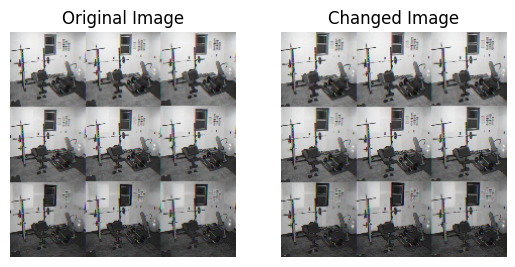

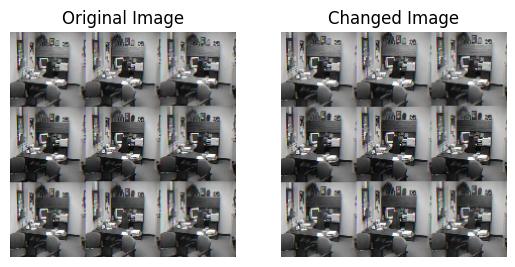

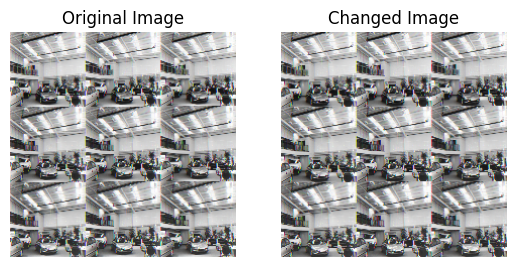

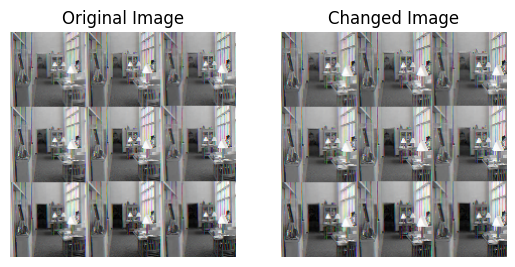

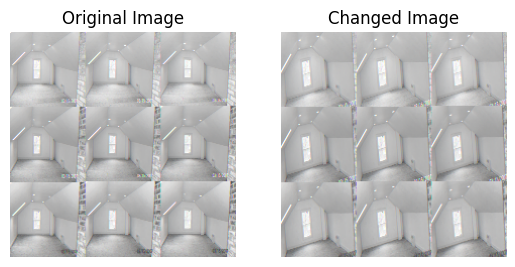

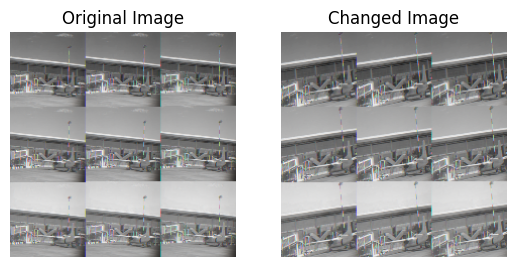

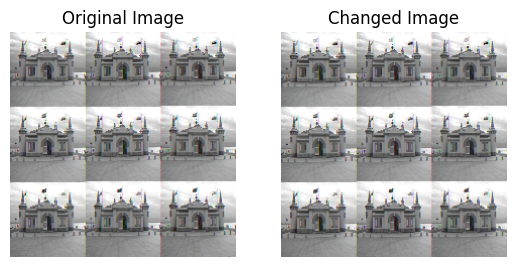

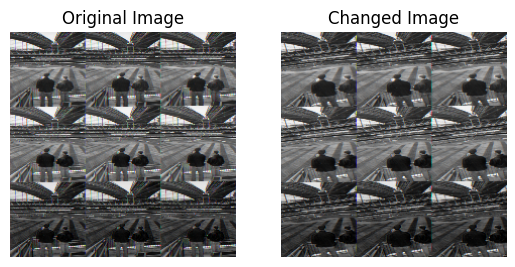

In [ ]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
# get a batch of train_loader
for imgs1,imgs2,labels in train_dataloader:
    images_1 = imgs1
    images_2 = imgs2
    label = labels
    break

plt.figure(figsize=(6,2))
# Plot a batch of train_loader
for i in range(8):
    plt.figure()
    img1 = images_1[i].reshape((224,224,3))
    img2 = images_2[i].reshape((224,224,3))
    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(img1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Changed Image')
    plt.imshow(img2)
    plt.axis('off')

در این قسمت هشت جفت تصویر از دیتاست تست نمایش داده شده است.

<Figure size 600x200 with 0 Axes>

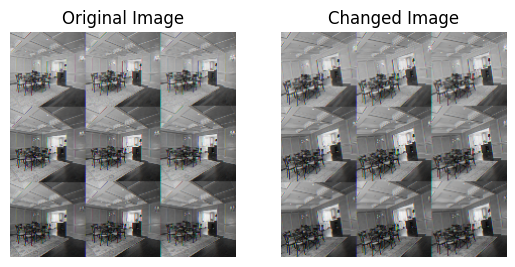

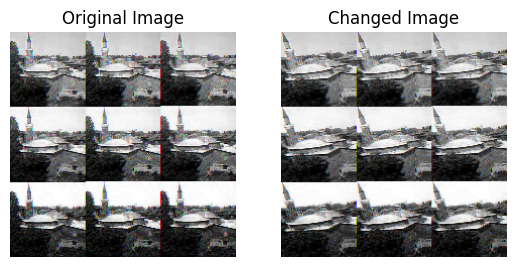

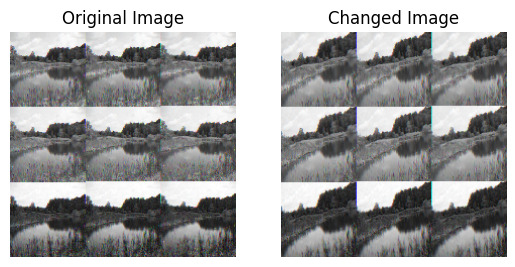

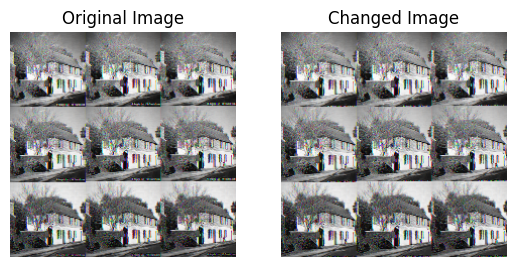

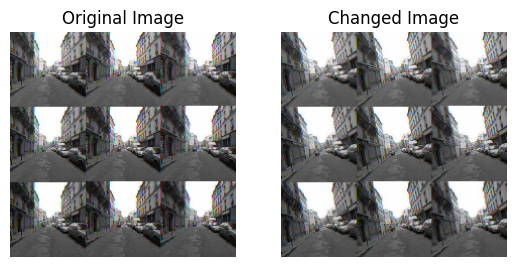

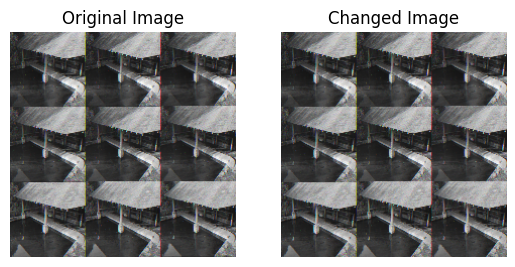

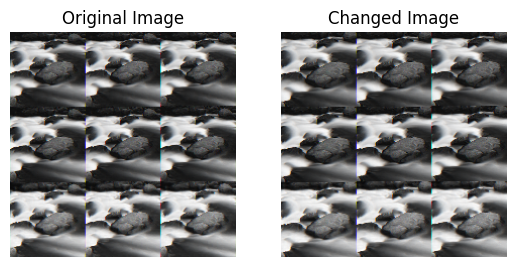

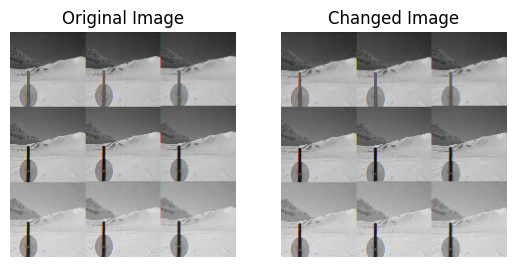

In [ ]:
# get a batch of test_loader
for imgs1,imgs2,labels in train_dataloader:
    images_1 = imgs1
    images_2 = imgs2
    label = labels
    break

plt.figure(figsize=(6,2))
# Plot a batch of test_loader
for i in range(8):
    plt.figure()
    img1 = images_1[i].reshape((224,224,3))
    img2 = images_2[i].reshape((224,224,3))
    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(img1)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('Changed Image')
    plt.imshow(img2)
    plt.axis('off')

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

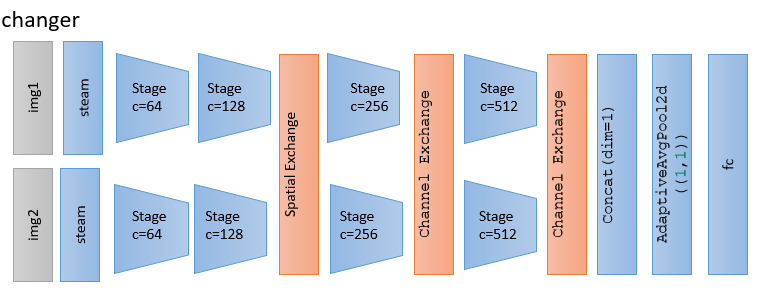

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


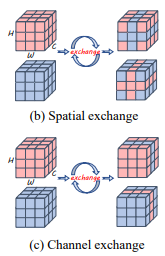

In [ ]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

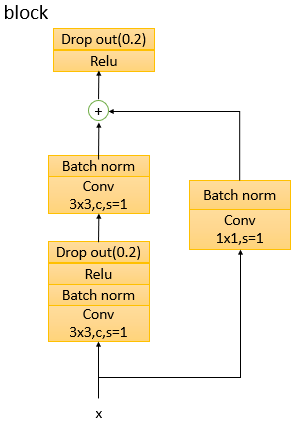

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





  بایستی تعداد کانال های خروجی کانوولوشن یک در یک برابر با همان کانال های خروجی مسیر سمت چپ که همان  تعداد فیلترهای هر کانوولوشن میباشد باشد یعنی همان مقدارc

با توجه به اینکه سایز فیلترها سه در سه است مقدار پدینگ را یک واحد درنظر گرفتم تا در فرایند کانوولوشن سایز تغییری نکند..

برای تنظیم تعداد کانال ها تا بتوان خروجی مسیر چپ را با مسیر راست جمع کنیم باید تعداد کانال ها یکسان باشد که این کار را با استفاده از کانوولوشن یک در یک انجام میدهیم.

In [ ]:
##To Do
class block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout_prob=0.2):
        super(block,self).__init__()

        self.forwardPath = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout_prob),
                nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels))

        self.resPath = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels))

        self.finalPath = nn.Sequential(
              nn.ReLU(inplace=True),
              nn.Dropout2d(p=dropout_prob))

    def forward(self,x):
        forwardpath_out = self.forwardPath(x)
        respath_out = self.resPath(x)
        out = self.finalPath(forwardpath_out+respath_out)
        return out

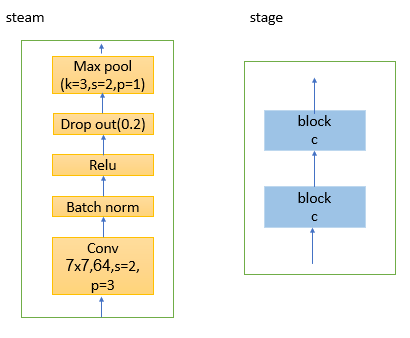

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [ ]:
#To Do
class changer(nn.Module):
    def __init__(self,block,SpatialExchange,ChannelExchange):
        super(changer,self).__init__()

        self.steam=nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1))

        self.stage1 = self._make_stage(block(in_channels=64, out_channels=64), block(in_channels=64, out_channels=64))
        self.stage2 = self._make_stage(block(in_channels=64, out_channels=128), block(in_channels=128, out_channels=128))
        self.stage3 = self._make_stage(block(in_channels=128, out_channels=256), block(in_channels=256, out_channels=256))
        self.stage4 = self._make_stage(block(in_channels=256, out_channels=512), block(in_channels=512, out_channels=512))

        self.spatial_ex = SpatialExchange()
        self.channel_ex_1 = ChannelExchange()
        self.channel_ex_2 = ChannelExchange()

        self.fc = nn.Linear(1024, 3)

        self.sigmoid = nn.Sigmoid()

    def _make_stage(self, block_1, block_2):
        layers = [block_1, block_2]
        return nn.Sequential(*layers)

    def forward(self,x1,x2):
        out_1 = self.steam(x1)
        out_2 = self.steam(x2)

        out_1 = self.stage1(out_1)
        out_2 = self.stage1(out_2)

        out_1 = self.stage2(out_1)
        out_2 = self.stage2(out_2)

        out_1,out2 = self.spatial_ex(out_1, out_2)

        out_1 = self.stage3(out_1)
        out_2 = self.stage3(out_2)

        out_1, out_2 = self.channel_ex_1(out_1, out_2)

        out_1 = self.stage4(out_1)
        out_2 = self.stage4(out_2)

        out_1, out_2 = self.channel_ex_2(out_1, out_2)

        combined_output = torch.cat((out_1, out_2), dim=1)

        combined_output = nn.AdaptiveAvgPool2d(1)(combined_output)

        combined_output = combined_output.view(combined_output.size(0), -1)

        out = self.fc(combined_output)

        out = self.sigmoid(out)

        return out

In [ ]:
## To Do
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

model=changer(block,SpatialExchange,ChannelExchange).to(device)

citeration = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.001)

##Train & validation


You can see the model performance and plots in following cells.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

Loss_train=[]
Loss_val=[]

acc_train = []
acc_val = []

train_preds = []
val_preds = []

# Training loop
def train(model, train_dataloader, val_dataloader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        running_loss = 0.0

        for inputs1, inputs2, labels in tqdm.tqdm(train_dataloader):
            # Assuming your model takes a pair of images as input
            outputs = model(inputs1.to(device), inputs2.to(device))
            labels = labels.to(device)
            # Convert labels to float
            labels = labels.float()

            # Compute the loss
            loss = criterion(outputs, labels)

            # Backpropagation and optimization

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update statistics
            running_loss += loss.item()
            total_samples += labels.size(0)
            total_correct += ((outputs > 0.5).float() == labels).sum().item()

        # Calculate training accuracy and validation loss
        train_accuracy = total_correct / (total_samples * 3)
        avg_loss = running_loss / len(train_dataloader)

        # Validation
        val_loss, val_accuracy = evaluate(model, val_dataloader, criterion)

        save_path = f'model_epoch_{epoch+1}.pth'
        # Save the entire model
        torch.save(model.state_dict(), save_path)

        Loss_train.append(avg_loss)
        Loss_val.append(val_loss)
        acc_train.append(train_accuracy)
        acc_val.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Training Loss: {avg_loss:.4f}, '
              f'Training Accuracy: {train_accuracy*100:.4f} %, '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy*100:.4f} %')

def evaluate(model, dataloader, criterion):
    model.eval()
    total_correct = 0
    total_samples = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs1, inputs2, labels in dataloader:
            # Assuming your model takes a pair of images as input
            outputs = model(inputs1.to(device), inputs2.to(device))
            labels = labels.to(device)

            # Convert labels to float (since BCELoss expects float targets)
            labels = labels.float()

            # Compute the loss
            loss = criterion(outputs, labels)

            # Update statistics
            running_loss += loss.item()
            total_samples += labels.size(0)
            total_correct += ((outputs > 0.5).float() == labels).sum().item()

    # Calculate accuracy and average loss
    accuracy = total_correct / (total_samples*3)
    avg_loss = running_loss / len(dataloader)

    return avg_loss, accuracy

# Train the model
train(model, train_dataloader, val_dataloader, citeration, optimizer, epochs=5)

100%|██████████| 2527/2527 [48:59<00:00,  1.16s/it]


Epoch [1/5], Training Loss: 0.6949, Training Accuracy: 51.8869 %, Validation Loss: 0.7271, Validation Accuracy: 49.2667 %


100%|██████████| 2527/2527 [49:06<00:00,  1.17s/it]


Epoch [2/5], Training Loss: 0.6840, Training Accuracy: 54.5407 %, Validation Loss: 0.7394, Validation Accuracy: 49.1833 %


100%|██████████| 2527/2527 [49:00<00:00,  1.16s/it]


Epoch [3/5], Training Loss: 0.6592, Training Accuracy: 58.7762 %, Validation Loss: 0.7204, Validation Accuracy: 50.0833 %


100%|██████████| 2527/2527 [49:01<00:00,  1.16s/it]


Epoch [4/5], Training Loss: 0.6160, Training Accuracy: 64.3345 %, Validation Loss: 0.7205, Validation Accuracy: 51.1833 %


100%|██████████| 2527/2527 [49:05<00:00,  1.17s/it]


Epoch [5/5], Training Loss: 0.5766, Training Accuracy: 67.6893 %, Validation Loss: 0.7247, Validation Accuracy: 51.5500 %


# Save Model

In [ ]:
# Save weights and shape
torch.save(model, 'model.pth')

# Plot Train and Validation Results

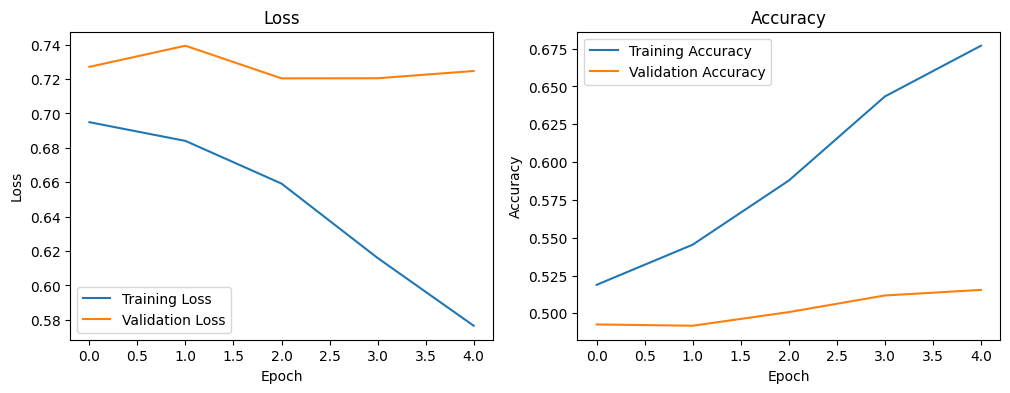

In [ ]:
plt.figure(figsize=(12, 4))
# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(Loss_train, label='Training Loss')
plt.plot(Loss_val, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(acc_train, label='Training Accuracy')
plt.plot(acc_val, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Test


In [ ]:
model = torch.load('model.pth')
test_preds = []
def test(model, dataloader, criterion):
    model.eval()
    total_correct = 0
    total_samples = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs1, inputs2, labels in dataloader:
            # Assuming your model takes a pair of images as input
            outputs = model(inputs1.to(device), inputs2.to(device))
            labels = labels.to(device)

            # Convert labels to float (since BCELoss expects float targets)
            labels = labels.float()

            # Compute the loss
            loss = criterion(outputs, labels)

            # Update statistics
            running_loss += loss.item()
            total_samples += labels.size(0)
            total_correct += ((outputs > 0.5).float() == labels).sum().item()

            # Save preds
            test_preds.append((outputs > 0.5).float())

    # Calculate accuracy and average loss
    accuracy = total_correct / (total_samples*3)
    avg_loss = running_loss / len(dataloader)

    return avg_loss, accuracy

test_loss, test_accuracy = test(model, test_dataloader, citeration)

print(f' loss_test= {test_loss:.3f}, acc_test={test_accuracy*100:.3f}')

 loss_test= 0.725, acc_test=51.550


**loss_test= 0.725, acc_test=51.550**

In [ ]:
# Calculate the number of true preds on one and two changed images
preds_list = []
for i in range(250):
    for j in range(8):
        preds_list.append(np.array(test_preds[i].cpu())[j])
pred_labels = np.array(preds_list)
one_changed_num = []
two_changed_num = []
true_one_changed_preds = []
true_two_changed_preds = []
for i in range(2000):
    pred = pred_labels[i]
    gt = test_labels[i]
    if gt.sum() == 1:
        one_changed_num.append((gt,pred))
        if (gt == pred.astype('uint8')).any():
            true_one_changed_preds.append((gt,pred))
    if gt.sum() == 2:
        two_changed_num.append((gt,pred))
        if (gt == pred.astype('uint8')).all():
            true_two_changed_preds.append((gt,pred))

In [ ]:
print('Test Accuracy on one changed samples:',len(true_one_changed_preds)/ len(one_changed_num) *100)
print('Test Accuracy on two changed samples:',len(true_two_changed_preds)/ len(two_changed_num) *100)

Test Accuracy on one changed samples: 67.85350966429297
Test Accuracy on two changed samples: 33.52999016715831


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

همانگونه که از نتایج بالا مشاهده میشود حدود 67 درصد از عکس های با یک تغییر و حدود 33 درصد از عکس های با دو تغییر درست تشخیص داده شده اند.و دقت کلی مدل حدود 52 درصد بر روی داده های تست میباشد.